# **Data** **Description**:
You are provided with a dataset of images of plant seedlings at various stages of grown. Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the project is to create a classifier capable of determining a plant's species from a photo. 
# **Dataset**:   
The dataset can be download from Olympus. 
The data file names are: 
(images.npy )&(Label.csv)
The original files are from Kaggle. Due to the large volume of data, the images were converted to images.npy file and the labels are also put into the Labels.csv. So that you can work on the data/project seamlessly without worrying about the high data volume

In [1]:
import cv2#reading and resizing                 
import numpy as np#arrays         
import os#dealing with directories                  
from random import shuffle #to shuffle data
from tqdm import tqdm#loop progress bar  
from sklearn.metrics import roc_auc_score    
import matplotlib.pyplot as plt # for visualizations
import tensorflow as tf # For tensor operations
import pandas as pd # for manipulating data
import zipfile
import os, sys

In [2]:
import keras 
import keras.backend as k
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.layers import Dense,Dropout,Flatten
from keras.layers.normalization import BatchNormalization
from keras import losses
from keras.optimizers import Adam,RMSprop,Adadelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.applications.vgg16 import preprocess_input,decode_predictions
import matplotlib.pyplot as plt

Upload the "images.npy" and “Labels.csv” file to google drive.


In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data=np.load("/content/drive/MyDrive/Dropbox/images.npy")

In [6]:
data.shape

(4750, 128, 128, 3)

In [7]:
from google.colab import files
uploaded = files.upload()


Saving labels.csv to labels (6).csv


In [8]:
label=pd.read_csv("labels.csv")

In [9]:
label

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
...,...
4745,Loose Silky-bent
4746,Loose Silky-bent
4747,Loose Silky-bent
4748,Loose Silky-bent


In [10]:
label.shape

(4750, 1)

In [11]:
label_data=pd.Series(label['Label'])
label_data

0       Small-flowered Cranesbill
1       Small-flowered Cranesbill
2       Small-flowered Cranesbill
3       Small-flowered Cranesbill
4       Small-flowered Cranesbill
                  ...            
4745             Loose Silky-bent
4746             Loose Silky-bent
4747             Loose Silky-bent
4748             Loose Silky-bent
4749             Loose Silky-bent
Name: Label, Length: 4750, dtype: object

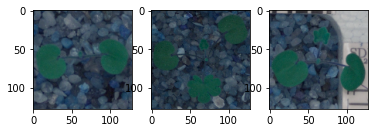

In [12]:
# Visualize data
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 3)
for i in range(3):
    ax[i].imshow(data[i])

**Data Pre-processing**

In [13]:
train_data=data

In [14]:
#Normalization
lb=LabelBinarizer()
label_data=lb.fit_transform(label_data)
train_data=train_data/255

In [15]:
train_data

array([[[[0.1372549 , 0.20392157, 0.30588235],
         [0.14117647, 0.19215686, 0.29803922],
         [0.12156863, 0.17647059, 0.27058824],
         ...,
         [0.30588235, 0.37254902, 0.44705882],
         [0.29803922, 0.36470588, 0.43137255],
         [0.31372549, 0.37254902, 0.42745098]],

        [[0.12941176, 0.18039216, 0.26666667],
         [0.14509804, 0.19607843, 0.28627451],
         [0.18823529, 0.25490196, 0.3254902 ],
         ...,
         [0.31764706, 0.37647059, 0.44313725],
         [0.29019608, 0.34901961, 0.41176471],
         [0.3254902 , 0.37254902, 0.42745098]],

        [[0.13333333, 0.19607843, 0.26666667],
         [0.1372549 , 0.20392157, 0.28235294],
         [0.2745098 , 0.33333333, 0.39607843],
         ...,
         [0.3254902 , 0.38039216, 0.43921569],
         [0.30980392, 0.36862745, 0.42352941],
         [0.30980392, 0.36862745, 0.41960784]],

        ...,

        [[0.1372549 , 0.19607843, 0.27058824],
         [0.16470588, 0.22352941, 0.28627451]

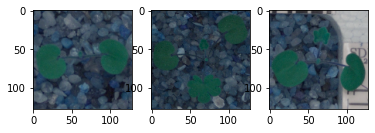

In [16]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 3)
for i in range(3):
    ax[i].imshow(train_data[i])

In [17]:
#gaussian bluring
from scipy.ndimage.filters import gaussian_filter

blurred = gaussian_filter(train_data, sigma=13)

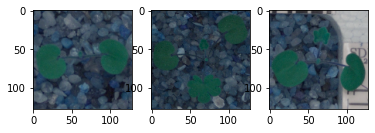

In [18]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 3)
for i in range(3):
    ax[i].imshow(train_data[i])

In [19]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()

enc.fit(label)

# 3. Transform
onehotlabels = enc.transform(label).toarray()
onehotlabels.shape


(4750, 12)

In [20]:
y=onehotlabels
x=train_data

In [21]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

**Training**

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=99)

In [23]:
x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5,random_state=99)

In [24]:
y_train.shape

(3325, 12)

In [25]:
y_test.shape

(712, 12)

In [26]:
y_val.shape

(713, 12)

In [27]:
print("x-tarin: ",x.shape,' x_test: ',x_test.shape," x_val: ",x_test.shape)
print("y-tarin: ",y_train.shape,' y_test: ',y_test.shape," y_val: ",y_test.shape)

x-tarin:  (4750, 128, 128, 3)  x_test:  (712, 128, 128, 3)  x_val:  (712, 128, 128, 3)
y-tarin:  (3325, 12)  y_test:  (712, 12)  y_val:  (712, 12)


In [28]:
# as first layer in a Sequential model  
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((128, 128, 3)))

In [29]:
model = tf.keras.models.Sequential()

# Input layer
# Can be omitted, you can specify the input_shape in other layers
model.add(tf.keras.layers.InputLayer(input_shape=(128,128,3)))

# Here we add a 2D Convolution layer
# Check https://keras.io/api/layers/convolution_layers/convolution2d/ for more info
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

# Max Pool layer 
# It downsmaples the input representetion within the pool_size size
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
# The layer normalizes its output using the mean and standard deviation of the current batch of inputs.
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Global Max Pool layer
model.add(tf.keras.layers.GlobalMaxPool2D())

# Dense Layers after flattening the data
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))

# Dropout
# is used to nullify the outputs that are very close to zero and thus can cause overfitting.
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

#Add Output Layer
model.add(tf.keras.layers.Dense(12, activation='softmax')) # = 12 predicted classes

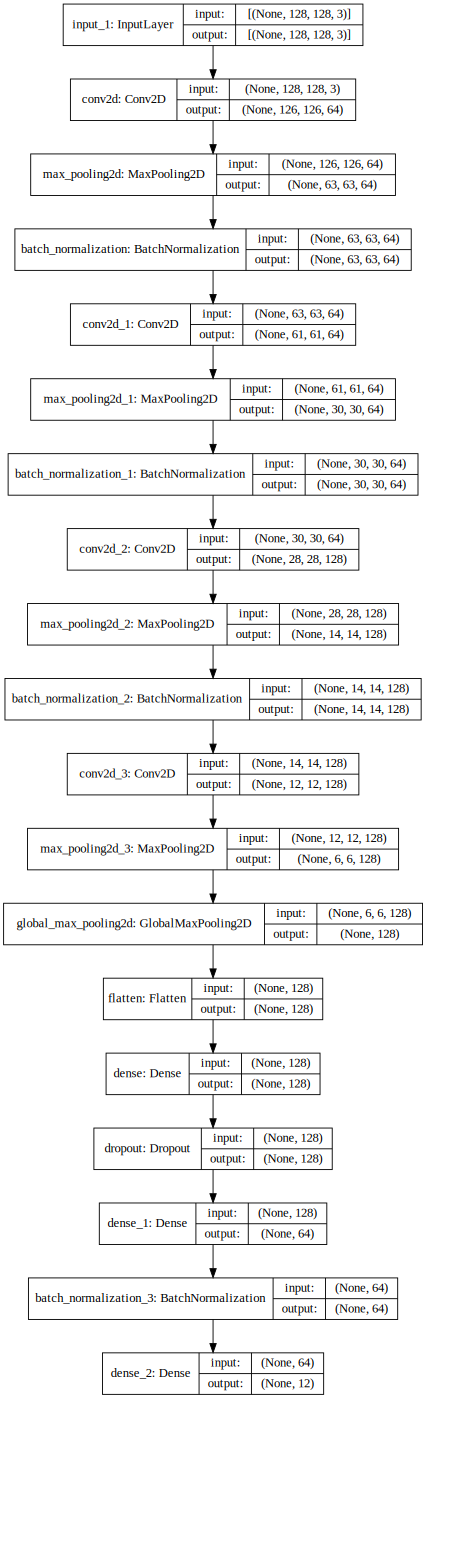

In [148]:
#Displaying SVG
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True,show_layer_names=True,rankdir='TB').create(prog='dot',format='svg'))
#resize the(svg)
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))


In [32]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=["accuracy"])

In [33]:
# after trying i found that batch_sixe=264 and epochs=100 giving the best accuracy
cnn=model.fit(x_train,y_train,batch_size=264,epochs=100,verbose=1,validation_data=(x_val,y_val),shuffle=True)

Epoch 1/100
13/13 [==============================] - 11s 528ms/step - loss: 2.7109 - accuracy: 0.1570 - val_loss: 2.4480 - val_accuracy: 0.1613
Epoch 2/100
13/13 [==============================] - 4s 277ms/step - loss: 1.8317 - accuracy: 0.3864 - val_loss: 2.4809 - val_accuracy: 0.1613
Epoch 3/100
13/13 [==============================] - 4s 274ms/step - loss: 1.4683 - accuracy: 0.5069 - val_loss: 2.5747 - val_accuracy: 0.1613
Epoch 4/100
13/13 [==============================] - 4s 278ms/step - loss: 1.1795 - accuracy: 0.6243 - val_loss: 2.6358 - val_accuracy: 0.1613
Epoch 5/100
13/13 [==============================] - 4s 278ms/step - loss: 0.9445 - accuracy: 0.7119 - val_loss: 2.7027 - val_accuracy: 0.1613
Epoch 6/100
13/13 [==============================] - 4s 277ms/step - loss: 0.7703 - accuracy: 0.7605 - val_loss: 2.8535 - val_accuracy: 0.1613
Epoch 7/100
13/13 [==============================] - 4s 278ms/step - loss: 0.6300 - accuracy: 0.8117 - val_loss: 2.9003 - val_accuracy: 0.161

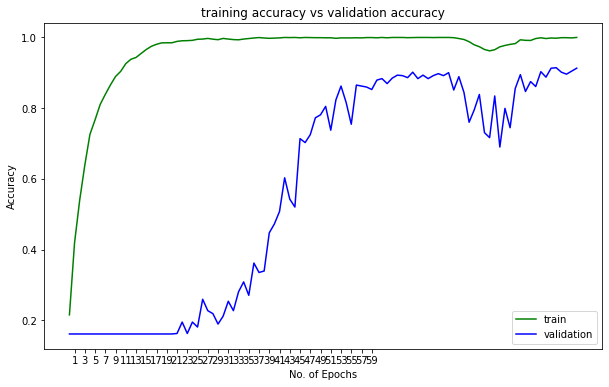

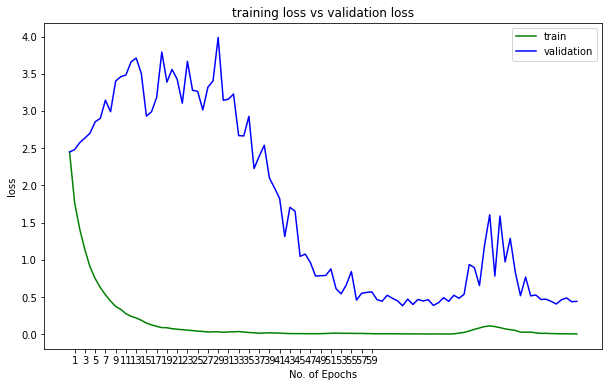

In [34]:
plt.figure(figsize=(10,6))
plt.plot(cnn.history['accuracy'],'g')
plt.plot(cnn.history['val_accuracy'],'b')
plt.xticks(np.arange(1,60,2))
plt.title('training accuracy vs validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'])
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cnn.history['loss'],'g')
plt.plot(cnn.history['val_loss'],'b')
plt.xticks(np.arange(1,60,2))
plt.title('training loss vs validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.show()


In [37]:
pred=model.predict(x_test,verbose=1)


23/23 [==============================] - 1s 13ms/step


In [38]:
#computing test acc
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(test_acc)


23/23 - 0s - loss: 0.4365 - accuracy: 0.9045
0.9044944047927856


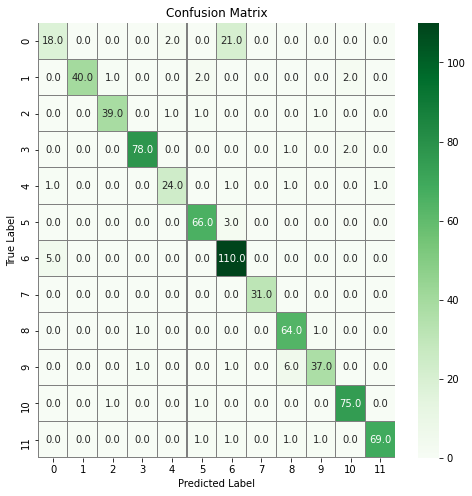

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Predict the values from the validation dataset
y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

 Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59].

AxesImage(54,36;334.8x217.44)
for x_test {2} y_pred =  [['Cleavers']]   /  y_test =  [['Cleavers']]


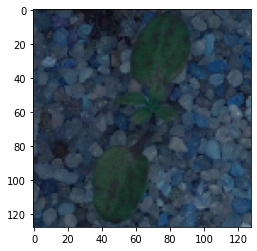

AxesImage(54,36;334.8x217.44)
for x_test {3} y_pred =  [['Charlock']]   /  y_test =  [['Charlock']]


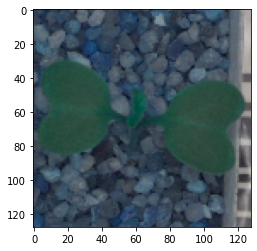

AxesImage(54,36;334.8x217.44)
for x_test {33} y_pred =  [['Fat Hen']]   /  y_test =  [['Fat Hen']]


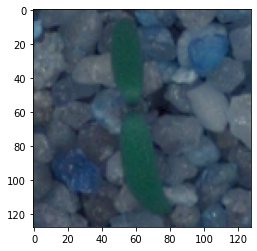

AxesImage(54,36;334.8x217.44)
for x_test {6} y_pred =  [['Common Chickweed']]   /  y_test =  [['Common Chickweed']]


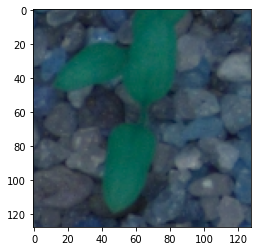

AxesImage(54,36;334.8x217.44)
for x_test {59} y_pred =  [['Charlock']]   /  y_test =  [['Charlock']]


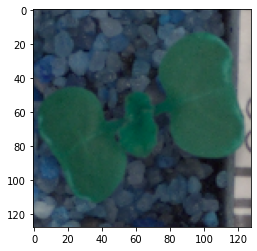

In [145]:
#looping through the test list for eval
for i in [2,3,33,6,59]:
  plt.show()
  print(plt.imshow(x_test[i]))
  print("for x_test",{i}, "y_pred = ",enc.inverse_transform(y_pred[i].reshape(1,-1)),"  /  y_test = ",enc.inverse_transform(y_test[i].reshape(1,-1)))
